# Stretch and shear experiments

When we solve the mechanical model, we are solving for an equilibrium of stresses. Here, both active and passive tension plays in, as well as boundary conditions. The passive tension is determined by a strain energy function. The matematical definition will determine the overall behavior – e.g. linear, exponential – together with numerical parameters determining the stiffness of the material for different deformation modes. These parameters are explicitly called _material parameters_, and determining these for cardiac tissue is a matter of current interest in the cardiac mechanics community.

The strain energy function is usually found by performing _stretch_ and _shear_ experiments of tissue samples (of cardiac tissue), often taken to be cubes. Cardiac tissue is known to be _fully orthotropic_, i.e., it has different stiffness properties along all three perpendicular axes.

As in the previous chapter, let's start by importing all libraries we need in this demo:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import fenics as f
import emimechanicalmodel as emi_m

f.set_log_level(30)        # less verbatim output from the Newton solver compared to default

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Next, we can start by reading in the mesh and subdomain information:

In [2]:
mesh_file = "tile_connected_10p0.h5"
mesh, volumes = emi_m.load_mesh(mesh_file)

Mesh and subdomains loaded successfully.
Number of nodes: 335, number of elements: 1364


## Fundamental equations

When we solve the mechanical problem, we want to find a displacement field $\mathbf{u}$ which gives us an _equilibrium of stresses_. We are, essentially, solving for a three-dimensional version of Newton's third law, expressed by Piola-Kirchhoff stress tensor $\mathbf{P}$:

$$\nabla \cdot \mathbf{P} = 0$$

In this section, we won't include any active contraction. Instead, we'll solve for an equilibrium given by the passive properties of the material _subject to boundary conditions_ which will give us the stretching and shearing deformation modes of interest. Here, $\mathbf{P}$ will depend on the deformation tensor $\mathbf{F}$ and a given strain energy $\Psi$:

$$ P = \frac{\partial \Psi (F)}{\partial F}$$

The two core ideas in the EMI model are that both $\psi_{passive}$ and $\psi_{active}$ are defined differently for each subdomain. For $\psi$ as given above, we can separate it into two separate contributions:

$$ \Psi (F) = \begin{cases} \Psi_{i} (F) \qquad x \in \Omega_i \\ \Psi_{e} (F) \qquad x \in \Omega_e \end{cases} $$

This is, as you might notice, _not_ defined at the membrane itself, i.e., the surface separating the two subdomains. That is, however, not so important; you might think of it as that we assume, for simplicity, that the membrane has zero stiffness (which is not exactly right, but it's a valid simplification).

## Deformation modes of interest

There are, in general, nine different deformation modes of interest used to determine the material parameters of cardiac tissue – three for stretching the material, and six for shearing the material in a diagonal manner.

<br />

<center>
<div>
<img src="../stretching_shearing_deformation_modes.png" width="500"/>
</div>
</center>

<br />

A: 25 % shear deformation of the fiber-sheet shear deformation mode $FS$. B: All nine deformation modes of interest. The white arrows display the direction we move a surface in, while the opposite surface remains fixed. The pink arrows display the normals of the same surfaces.

----

There are two ways to perform stretching (and shearing) experiments. They are two sides of the same coin; applying one approach we can calculate the result in the other, and vice versa. One way, and prehaps the most normal one, is to apply a load on one surface while fixing the opposite one. That will result in that the domain moves on one side, from which one can calculate a resulting displacement. For the EMI model, however, since we have different intra- and extracellular stiffness properties this would result in a spatially varying displacement, dependent on the cellular geometry.

The other one, which we will use in our model, is to prescribe a displacement. For a given displacement (i.e., a given stretch value) we can, based on the resulting stress values, calculate the resulting load on a given surface. We will prescribe the stretch using a constant value; and the resulting load will then be a spatially varying variable. When we report on the load values, this is actually calculated as a surface integral over the given surface, normalized by the surface area.



## Running the EMI model

With the theory explained, let's get the model running! From the emimechanicalmodel library, we can make an instance of the EMI model which is based on all the equations above. The instances will be defined differently for each stretching and shearing mode.

### Stretching experiments

Let's first perform the three stretching experiments – in the fiber, sheet, and normal directions. As we stretch the domain in different direcitons, we'll track the (averaged) normal load values.

length=102.0, width=20.0, height=24.0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
length=102.0, width=20.0, height=24.0
Calling FFC just-in-time (JIT) compiler, this may take some time.
length=102.0, width=20.0, height=24.0
Calling FFC just-in-time (JIT) compiler, this may take some time.


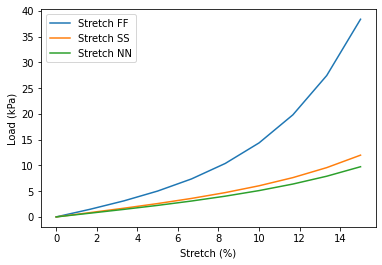

In [13]:

deformation_modes = ["stretch_ff", "stretch_ss", "stretch_nn"]
labels = ["Stretch FF", "Stretch SS", "Stretch NN"]

stretch_values = np.linspace(0, 0.15, 10)           # up to 15 % in 10 steps

for deformation_mode, label in zip(deformation_modes, labels):

    emimodel = emi_m.EMIModel(
            mesh,
            volumes,
            experiment=deformation_mode,
        )

    load_values = np.zeros_like(stretch_values)
    
    # then run the simulation
    for step, stretch_value in enumerate(stretch_values):
        emimodel.assign_stretch(stretch_value)
        emimodel.solve()
        
        load_values[step] = emimodel.evaluate_normal_load()
    
    plt.plot(100*stretch_values, load_values, label=label)

plt.xlabel("Stretch (%)")
plt.ylabel("Load (kPa)")

plt.legend()
plt.show()

### Shearing experiments

In a similar manner, we can perform shear experiments simply by specifying what kind of experiments we want to perform. For these, we'll track both normal and shear load values (which were coinciding for the stretching experiments):

In [ ]:

deformation_modes = ["shear_fs", "shear_fn", "shear_sf", "shear_sn", "shear_nf", "shear_ns"]
labels = ["Shear FS", "Shear FN", "Shear SF", "Shear SN", "Shear NF", "Shear NS"]

stretch_values = np.linspace(0, 0.4, 20)           # up to 40 % in 20 steps

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharey=True, sharex=True)

for deformation_mode, label in zip(deformation_modes, labels):

    emimodel = emi_m.EMIModel(
            mesh,
            volumes,
            experiment=deformation_mode,
        )

    normal_load_values = np.zeros_like(stretch_values)
    shear_load_values = np.zeros_like(stretch_values)
    
    # then run the simulation
    for step, stretch_value in enumerate(stretch_values):
        emimodel.assign_stretch(stretch_value)
        emimodel.solve()
        
        normal_load_values[step] = emimodel.evaluate_normal_load()
        shear_load_values[step] = emimodel.evaluate_shear_load()
    
    axes[0].plot(100*stretch_values, normal_load_values, label=label)
    axes[1].plot(100*stretch_values, shear_load_values, label=label)

axes[0].set_xlabel("Shear (%)")
axes[1].set_xlabel("Shear (%)")
axes[0].set_ylabel("Load (kPa)")

axes[0].set_title("Normal load")
axes[1].set_title("Shear load")

axes[0].legend()
axes[1].legend()

plt.legend()
plt.show()

length=102.0, width=20.0, height=24.0
length=102.0, width=20.0, height=24.0


In the second paper we used all of these experiments for parametrization of the model; see methods section for more details.